## Step by Step
* Create global variables 
* Get dataset from yahoo web page
* Create column for prediction with price values closed
* Clean data removing NAN 
* Separate dataset for training and validation
* Create the prediction array by time 
* Create Linear Regression Model 
* Create Lasso Model
* Create Ridge Model
* Compare the score of the three models
* Create a graph with the price prediction with 3 models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Create global variables 

In [2]:
start = datetime(2014,1, 1)
end = datetime.now()
days = 10
stocks = 'WEGE3.SA';

### Get dataset from yahoo web page
[Yahoo finance](https://finance.yahoo.com/)

In [3]:
#https://finance.yahoo.com/
df = web.DataReader([stocks],'yahoo',start=start,end=end)  
df.tail()

Attributes,High,Low,Open,Close,Volume,Adj Close
Symbols,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA
Date,,,,,,
2019-08-30,22.700001,22.230000,22.469999,22.500000,3918200.0,22.500000
2019-09-02,23.030001,22.290001,22.500000,22.780001,2379200.0,22.780001
2019-09-03,23.110001,22.190001,22.820000,22.190001,3862700.0,22.190001
2019-09-04,22.709999,22.350000,22.500000,22.629999,2905900.0,22.629999
2019-09-05,23.139999,22.750000,22.820000,22.780001,2081900.0,22.780001


### Create column for prediction with price values closed

In [4]:
df['prediction'] = df['Close'].shift(days)

### Clean data removing NAN

In [5]:
df.dropna(inplace=True)
df.tail()

Attributes,High,Low,Open,Close,Volume,Adj Close,prediction
Symbols,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA,WEGE3.SA,
Date,,,,,,,
2019-08-30,22.700001,22.230000,22.469999,22.500000,3918200.0,22.500000,22.799999
2019-09-02,23.030001,22.290001,22.500000,22.780001,2379200.0,22.780001,22.540001
2019-09-03,23.110001,22.190001,22.820000,22.190001,3862700.0,22.190001,22.600000
2019-09-04,22.709999,22.350000,22.500000,22.629999,2905900.0,22.629999,23.059999
2019-09-05,23.139999,22.750000,22.820000,22.780001,2081900.0,22.780001,22.730000


### Separate dataset for training and validation

In [6]:
forecast_time = int(days)

X = np.array(df.drop(['prediction'], 1))
Y = np.array(df['prediction'])
Y = Y[:-forecast_time]
X = X[:-forecast_time]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

#### Create the prediction array by time 

In [7]:
x_forecast = np.array(df.drop(['prediction'],1))[-forecast_time:]

### Create Linear Regression Model 
[Linear Regressor Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [8]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()  
regressor.fit(x_train, y_train)

regressor_score = round(regressor.score(x_test, y_test) * 100, 2)
print("Linear Regressor Score - > ", regressor_score)
regressor_predictions = regressor.predict(x_forecast)

Linear Regressor Score - >  96.11


### Create Lasso Model
[Lasso Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [9]:

lasso = linear_model.Lasso(alpha=0.5, max_iter=2000)
lasso.fit(x_train, y_train)

lasso_score = round(lasso.score(x_test, y_test) * 100, 2)
print("Lasso - > ", lasso_score)

lasso_predictions = lasso.predict(x_forecast)

Lasso - >  95.88


### Create Ridge Model
[Ridge Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [10]:
ridge = linear_model.Ridge(alpha=25.5, max_iter=2000)
ridge.fit(x_train, y_train)

ridge_score = round(ridge.score(x_test, y_test) * 100, 2)
print("Linear Ridge - > ", ridge_score)

ridge_predictions = ridge.predict(x_forecast)

Linear Ridge - >  96.04


### Compare the score of the three models

In [11]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Lasso', 'Ridge'],
    'Score': [regressor_score, lasso_score, ridge_score]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Linear Regression,96.11
2,Ridge,96.04
1,Lasso,95.88


### Create a graph with the price prediction with 3 models

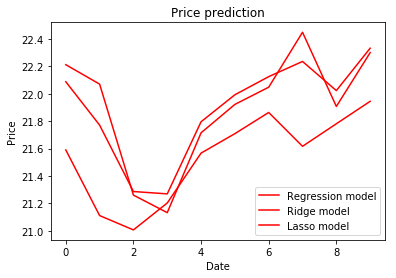

In [12]:
days_array = np.arange(days)
plt.plot(days_array, regressor_predictions, color='red', label = 'Regression model')
plt.plot(days_array, ridge_predictions, color='red', label = 'Ridge model')
plt.plot(days_array, lasso_predictions, color='red', label = 'Lasso model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price prediction')
plt.legend()

## Reference:
* [Sckit Guide](https://scikit-learn.org/stable/user_guide.html)
* [Predicting Stock Prices - Learn Python for Data Science - Youtube](https://www.youtube.com/watch?v=SSu00IRRraY)
* [Predict Stock Prices Using Python & Machine Learning - Medium](https://medium.com/@randerson112358/predict-stock-prices-using-python-machine-learning-53aa024da20a)

In [13]:
import sklearn
import numpy
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The Numpy version is {}.'.format(numpy.__version__))
print('The Pandas version is {}.'.format(pd.__version__))
import sys
print('Python version is {}.'.format(sys.version))

The scikit-learn version is 0.19.1.
The Numpy version is 1.17.1.
The Pandas version is 0.25.1.
Python version is 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)].
